## Study on Dataset Size requirements of the different models with smart splitting

### Import dependancies


In [1]:
import os
import torch
import copy
from geom3d import train_models
from geom3d.train_models import Pymodel
from geom3d.train_models import read_config, load_data, train_val_test_split, model_setup
import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Inference test function to extract MAE, MSE from model checkpoints

In [2]:
def test_model(chkpt_path, config_dir):
    config = read_config(config_dir)
    np.random.seed(config["seed"])
    torch.cuda.manual_seed_all(config["seed"])
    torch.manual_seed(config["seed"])
    config["device"] = "cuda:0" if torch.cuda.is_available() else "cpu"

    print('checkpoint used:', chkpt_path)
    checkpoint = torch.load(chkpt_path)
    model, graph_pred_linear = model_setup(config)
    print("Model loaded: ", config["model_name"])

    # Pass the model and graph_pred_linear to the Pymodel constructor
    pymodel = Pymodel(model, graph_pred_linear, config)
    # Load the state dictionary
    pymodel.load_state_dict(state_dict=checkpoint['state_dict'])
    # Set the model to evaluation mode
    pymodel.eval()

    dataset = load_data(config)
    np.random.seed(config["seed"])
    torch.cuda.manual_seed_all(config["seed"])
    pymodel = pymodel.to(config["device"])

    train_loader, val_loader, test_loader = train_val_test_split(
        dataset, config=config, batch_size=config["batch_size"]
    )

    print("pymodel device", pymodel.device)
    print("Target: ", config["target_name"])

    # Get the y values from the dataset for setting plot axes
    y_values = [data.y for data in dataset]

    y_true = []
    y_pred = []
    for x in test_loader:
        with torch.no_grad():
            Y_pred = pymodel(x.to(config["device"]))
        y_true.append(x.y.to('cpu'))
        y_pred.append(Y_pred.to('cpu').detach())
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    print('Mean Absolute Error (MAE) on test_set:', mae)

    # calculate the mean squared error
    mse = mean_squared_error(y_true, y_pred)
    print('Mean Squared Error (MSE) on test_set:', mse)

    return mae, mse


### Automated process to retrieve errors for different dataset sizes on trained models with smart splitter

In [3]:
import os
import pandas as pd

model_names = ['PaiNN', 'SchNet', 'DimeNet', 'DimeNetPlusPlus', 'SphereNet', 'Equiformer']
num_mols = [80000, 40000, 10000, 5000]
mse_data = {}
epoch_data = {} 
# Loop over model names
for model_name in model_names:
    mse_values = []
    epoch_values = []  # List to store epoch values
    # Loop over number of molecules
    for num_mol in num_mols:
        config_dir = f"/rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/{model_name}_opt_combined_{num_mol}_smart"
        # Find the checkpoint path
        for file in os.listdir(config_dir):
            if file.endswith(".ckpt"):
                chkpt_path = os.path.join(config_dir, file)
                # Extract epoch number from the file name
                epoch = int(file.split('epoch=')[1].split('-')[0])  # Extract the epoch number
                epoch_values.append(epoch)
                break  # Break after finding the first checkpoint file
        mae, mse = test_model(chkpt_path, config_dir)
        mse_values.append(mse)

    mse_data[model_name] = mse_values
    epoch_data[model_name] = epoch_values

# Create DataFrames
df = pd.DataFrame(mse_data, index=num_mols)
df_2 = pd.DataFrame(epoch_data, index=num_mols)

print("MSE DataFrame:")
print(df)
print("\nEpoch DataFrame:")
print(df_2)

    

config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/PaiNN_opt_combined_80000_smart
checkpoint used: /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/PaiNN_opt_combined_80000_smart/epoch=62-val_loss=0.41-other_metric=0.00.ckpt
Model loaded:  PaiNN
/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasets/80000dataset_radius_combined.pt
Loading dataset split indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/datasplit_80000_smart.npz
train_idx:  [    0     3     4 ... 79997 79998 79999]
valid_idx:  [65542 32780 65549 ... 65530 65531 32766]
test_idx:  [    1 65541     7 ... 65529 32762 32765]
set()
set()
Number of training samples: 46464
Number of validation samples: 7431
Number of test samples: 7836
pymodel device cuda:0
Target:  combined
Mean Absolute Error (MAE) on test_set: 0.40765774
Mean Squared Error (MSE) on test_set: 0.44687694
config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/

/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support

Model loaded:  Equiformer
/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasets/80000dataset_combined.pt
Loading dataset split indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/datasplit_80000_smart.npz
train_idx:  [    0     3     4 ... 79997 79998 79999]
valid_idx:  [65542 32780 65549 ... 65530 65531 32766]
test_idx:  [    1 65541     7 ... 65529 32762 32765]
set()
set()
Number of training samples: 46464
Number of validation samples: 7431
Number of test samples: 7836
pymodel device cuda:0
Target:  combined
Mean Absolute Error (MAE) on test_set: 0.3710441
Mean Squared Error (MSE) on test_set: 0.396808
config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/Equiformer_opt_combined_40000_smart
checkpoint used: /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/Equiformer_opt_combined_40000_smart/epoch=87-val_loss=0.36-other_metric=0.00.ckpt


/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


Model loaded:  Equiformer
/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasets/80000dataset_combined.pt
Loading dataset split indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/datasplit_40000_smart.npz
train_idx:  [65537 65538 65539 ... 65527 65532 65533]
valid_idx:  [    3 40965     8 ... 16373 24565 49148]
test_idx:  [    2 32774 49160 ... 73724 32766 24575]
set()
set()
Number of training samples: 29468
Number of validation samples: 3927
Number of test samples: 3983
pymodel device cuda:0
Target:  combined
Mean Absolute Error (MAE) on test_set: 0.35945144
Mean Squared Error (MSE) on test_set: 0.37073475
config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/Equiformer_opt_combined_10000_smart
checkpoint used: /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/Equiformer_opt_combined_10000_smart/epoch=83-val_loss=0.59-other_metric=0.00.ckpt


/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


Model loaded:  Equiformer
/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasets/80000dataset_combined.pt
Loading dataset split indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/datasplit_10000_smart.npz
train_idx:  [49153 65538 16389 ... 32760 32765 49151]
valid_idx:  [49158 57351 36872 77830 61447 18444 57359 45072  6163 45079 12312 20509
 32806    39 73772 67629 36912 10290 26674 47156 59443 55350 10295 71732
 18489  6203 30781 65598 16447 67647 63553  4164 24644 57420 18509 47182
 28752 14418 38994 55382 30807 30808 63579 32860 71771 34911 36962 28772
 57445 71783  6252  6259 22644 39028  2167 43131 24700 32893 55422 71812
  2181  6278  8327 18566 63623 75915 14478 30862 41106 39062 69785 73881
 14491 47259 55453 65692 53407 18592 67739   164 57508 14504 47273 67754
  6318  8372 12480 49344 59588 32969 65738 41163 67788 24782 71886 51408
  8401  6354 73939 18645 26840  6364 37084 49374 41183 71907 41191 30952
  2281 59628 33008 14578 73972 35062 57592 1663

/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


Model loaded:  Equiformer
/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasets/80000dataset_combined.pt
Loading dataset split indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/datasplit_5000_smart.npz
train_idx:  [16389 24583 32776 ... 73724 32765 49151]
valid_idx:  [12293     7 28683 18444 20496 24595 14358 16406 38934  8219 73756 14367
 12324  2094 73774 55344 12343 57399  6203    60 30781 51261  2112 24642
 45123 75846 14415 38999 26712 36954 49246 34911 45158 28776 45168 36980
 10358 73850 24700 75907 63623 14472 67720 57482 43149 18582 43160 47259
 55453 39085   174 16557 59566 30904 69817 22715  4287 55498 55503 10449
 73938 78034 10455 26840 30939 49371 49372 47330 47332 35045 55532 22772
 67828 55542 73973   249 41210 47353 67833 20736 28931 41219 16649 49421
 24847 71952  6420  8471  6426 41243 61729 57637 20779 57643   307 53560
 69947 41282  6467 16710 51526 14666 33100 41303 41306 69991 51560 61805
  8559 53615 41329 51569 33153 43393 24965 35216

In [4]:
# Save the DataFrames to csv files at the current directory
df.to_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/smart_mse_data.csv')
df_2.to_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/smart_datasize_study/smart_epoch_data.csv')

### Plotting how the difference in error between different dataset sizes for the different models

In [6]:
%matplotlib inline

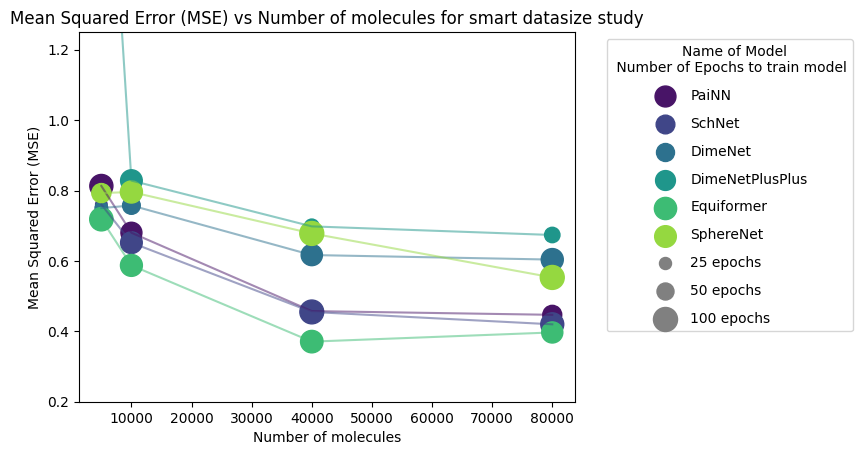

Improvement in MSE from 40000 to 80000 molecules:
PaiNN: -2.37%
SchNet: -8.36%
DimeNet: -2.14%
DimeNetPlusPlus: -3.63%
SphereNet: -22.60%
Equiformer: 6.57%
Average improvement in MSE from 40000 to 80000 molecules:
-5.42%


In [10]:
# plot only PaiNN and SchNet

import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots()

# Set labels
ax.set_xlabel('Number of molecules')
ax.set_ylabel('Mean Squared Error (MSE)')

# Set color palette to one that uses red to yellow
colors = sns.color_palette('viridis', n_colors=max(len(df.columns) * 3, 2))  # Ensure at least 2 colors

# Iterate over the model data only for PaiNN and SchNet
for i, (colname, coldata) in enumerate(df[['PaiNN', 'SchNet', 'DimeNet', 'DimeNetPlusPlus', 'Equiformer', 'SphereNet']].items()):
    epochs = df_2[colname]  # Get epochs data for this model
    
    # Adjust marker size based on the number of epochs
    marker_size = epochs * 3  # You can adjust the scaling factor as needed
    
    # Plot with adjusted marker size and color
    ax.scatter(coldata.index, coldata, s=marker_size, color=colors[i * 3 % len(colors)], label=f'{colname}')
    
    # Add thin line connecting the dots
    ax.plot(coldata.index, coldata, color=colors[i * 3 % len(colors)], linestyle='-', alpha=0.5)

# Add dummy scatter plots with different marker sizes to legend
for size in [25, 50, 100]:
    ax.scatter([], [], s=size*3, label=f'{size} epochs', color='grey', alpha=1)

# Display legend outside the graph
plt.legend(scatterpoints=1, labelspacing=1, title='                Name of Model \n Number of Epochs to train model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Mean Squared Error (MSE) vs Number of molecules for smart datasize study')
plt.ylim(0.2, 1.25)
plt.show()

# calculate on average how much all models have improved from 40000 to 80000 molecules
improvement = {}
for model_name in model_names:
    improvement[model_name] = (mse_data[model_name][0] - mse_data[model_name][1]) / mse_data[model_name][0] * 100

print("Improvement in MSE from 40000 to 80000 molecules:")
for model_name, value in improvement.items():
    print(f"{model_name}: {value:.2f}%")

print("Average improvement in MSE from 40000 to 80000 molecules:")
average_improvement = sum(improvement.values()) / len(improvement)
print(f"{average_improvement:.2f}%")